In [2]:
import sys
import os
current_dir = os.path.dirname(os.path.abspath('./'))
if not current_dir in sys.path:
    sys.path.append(current_dir)

import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as sig
from utils.signal import random_walk
from utils.datagen import SignalGenerator
from typing import Union
from utils.signal import band_limited_noise
from utils import save_pkl, read_pkl
import scipy as sp
import random
from typing import *
import sklearn.model_selection as skm
from alltools.machine_learning.designer import *
import tensorflow_addons as tfa

def ranks(sample):
    indices = sorted(range(len(sample)), key=lambda i: sample[i])
    return sorted(indices, key=lambda i: indices[i])

def sample_with_minimum_distance(n=40, k=4, d=10):
    sample = random.sample(range(n-(k-1)*(d-1)), k)
    return np.array([s + (d-1)*r for s, r in zip(sample, ranks(sample))])

def zero_one(sig):
    assert sig.ndim == 1
    return (sig - sig.min())/(sig.max() - sig.min())

def make_spikes(tc, peak_coords, spike_tc):
    if not isinstance(peak_coords, (list, tuple, np.ndarray)):
        peak_coords = [peak_coords]

    spike_samples_before_peak = np.where(spike_tc == np.max(spike_tc))[0][0]

    for peak in peak_coords:
        spike_startsample = peak - spike_samples_before_peak
        spike_endsample = spike_startsample + len(spike_tc)

        if spike_startsample >= 0:
            startsample = 0
        else:
            startsample = -spike_startsample
            spike_startsample = 0
        if spike_endsample <= len(tc):
            endsample = 0
        else:
            endsample = len(spike_tc) - (spike_endsample - len(tc))
            spike_endsample = 0

        tc[spike_startsample:spike_endsample - 1] += spike_tc[startsample:endsample - 1]
    return tc


class SpikesDatasetGenerator(SignalGenerator):
    def __init__(
        self,
        tmin: Union[int, float],
        tmax: Union[int, float],
        sfreq: int,
        n_spikes: Union[int, tuple[int, int]],
        n_channels: int,
        spike_chance: Optional[float] = 1.,
        spike_negativity_chance: Optional[float] = 0.,
        spike_deviation: Optional[float] = 0.,
        spike_amplitude_deviation: Optional[Union[float, tuple[float, float]]] = 1,
        spike_fun: Optional[Callable] = None,
        *args,
        **kwargs
    ):
        super().__init__(tmin, tmax, sfreq)
        self._n_spikes = n_spikes
        self._n_channels = n_channels
        self._spike_chance = spike_chance
        self._spike_fun = spike_fun if spike_fun is not None else lambda: sig.daub(10)
        dev = int(np.rint(spike_deviation*self._sfreq))
        self._spike_deviation = dev if dev > 0 else 1
        self._spike_fun_args = args
        self._spike_fun_kwargs = kwargs
        self._spike_amplitude_deviation = spike_amplitude_deviation
        self._spike_negativity_chance = spike_negativity_chance
        self._spike = sp.stats.zscore(self._spike_fun(*self._spike_fun_args, **self._spike_fun_kwargs))

    def __call__(self, n_datasamples: int):
        for _ in range(n_datasamples):
            n_spikes = self._n_spikes if isinstance(self._n_spikes, int) else np.random.randint(*self._n_spikes)
            peak_times = sample_with_minimum_distance(len(self._x), n_spikes, len(self._spike))
            # print(peak_times)
            data = list()
            for _ in range(self._n_channels):
                sig = sp.stats.zscore(random_walk(self._x)) +\
                    sp.stats.zscore(
                        band_limited_noise(
                            0,
                            self._sfreq // 2,
                            self._n_samples,
                            samplespacing=1 / self._sfreq
                        )
                )
                peaks = np.array([
                    # to get rid of situation when peak goes out of signal
                    min(peak_time + np.random.randint(2 * self._spike_deviation) - self._spike_deviation, len(sig)-1)
                    for peak_time in peak_times
                ])
                for peak in peaks:
                    amplitude_ratio = self._spike_amplitude_deviation\
                        if isinstance(self._spike_amplitude_deviation, (int, float))\
                        else random.uniform(*self._spike_amplitude_deviation)
                    if np.random.random() <= self._spike_chance:
                        pos = -1 if np.random.random() <= self._spike_negativity_chance else 1
                        sig = make_spikes(sig, peak, pos*amplitude_ratio*self._spike)
                data.append(sig)
            yield np.array(data), peak_times

2022-06-15 13:21:43.130735: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-15 13:21:43.130762: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


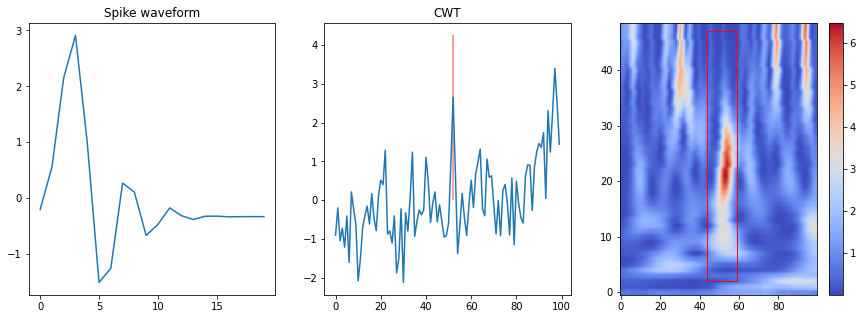

In [13]:
from utils.signal import compute_morlet_cwt
from utils import normal_rows
import matplotlib.patches as patches

class NoisySignal(SignalGenerator):
    def __init__(
        self,
        tmin: Union[int, float],
        tmax: Union[int, float],
        sfreq: int,
        **kwargs
    ):
        super().__init__(tmin, tmax, sfreq)
        self._fir_kwargs = kwargs

    def __call__(self, n_datasamples: int):
        for _ in range(n_datasamples):
            sig = sp.stats.zscore(random_walk(self._x)) +\
                sp.stats.zscore(
                    band_limited_noise(
                        0,
                        self._sfreq // 2,
                        self._n_samples,
                        samplespacing=1 / self._sfreq
                    )
            )
            yield sig


n_channels = 64
sfreq = 100
tmin = 0
tmax = 1

noisy = NoisySignal(tmin, tmax, sfreq)
data = np.array([
    channel
    for channel in noisy(n_channels)
])

spike = sp.stats.zscore(sig.daub(min(sfreq//10, 34)))
x = sp.stats.zscore(data[1])
spike_starttime = np.random.randint(len(x) - len(spike))
spike_peaktime = np.where(spike == np.max(spike))[0][0]
x[spike_starttime:spike_starttime+len(spike)] += spike

fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
ax1.plot(spike)
ax2.vlines(spike_starttime + spike_peaktime, 0, np.max(x)+.25*np.max(x), 'r', linewidth=1.5, alpha=.5)
ax2.plot(x)

freqs = np.arange(1, sfreq // 2)
cwtmatr = compute_morlet_cwt(x, np.arange(sfreq)/sfreq, freqs)
mapable = ax3.imshow(
    normal_rows(cwtmatr),
    # cwtmatr,
    aspect='auto',
    origin='lower',
    cmap='coolwarm',
)
rect = patches.Rectangle((spike_starttime-5, 2), 15, sfreq//2-5, linewidth=1, edgecolor='r', facecolor='none')
ax3.add_patch(rect)
ax1.set_title('Spike waveform')
ax2.set_title('Signal')
ax2.set_title('CWT')
fig.set_size_inches(15, 5)
plt.colorbar(mapable, ax=ax3)
plt.show()

[ 1 22 85]


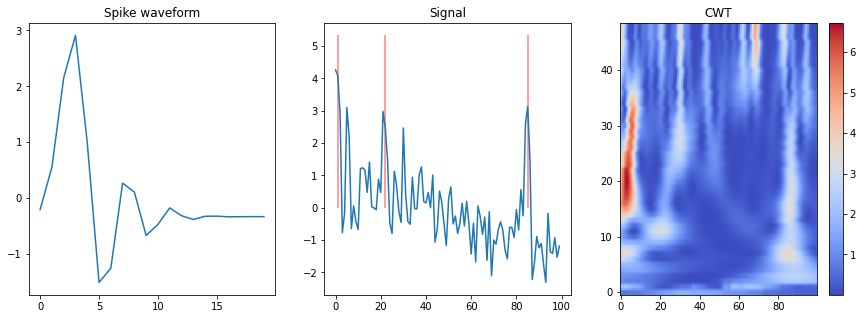

In [14]:
n_peaks = 3

x = sp.stats.zscore(data[np.random.randint(64)])
spike_tc = sp.stats.zscore(sig.daub(10))

peak_times = sample_with_minimum_distance(sfreq, n_peaks, len(spike_tc))
print(peak_times)
tc = make_spikes(x, peak_times, spike_tc)
# plt.plot(tc)
# plt.vlines(peak_times, 0, np.max(tc)+.25*np.max(tc), 'r', linewidth=1.5, alpha=.5)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
ax1.plot(spike_tc)
ax2.vlines(peak_times, 0, np.max(tc)+.25*np.max(tc), 'r', linewidth=1.5, alpha=.5)
ax2.plot(x)

freqs = np.arange(1, sfreq // 2)
cwtmatr = compute_morlet_cwt(x, np.arange(sfreq)/sfreq, freqs)
mapable = ax3.imshow(
    normal_rows(cwtmatr),
    # cwtmatr,
    aspect='auto',
    origin='lower',
    cmap='coolwarm',
)
# rect = patches.Rectangle((spike_starttime-5, 2), 15, sfreq//2-5, linewidth=1, edgecolor='r', facecolor='none')
# ax3.add_patch(rect)
ax1.set_title('Spike waveform')
ax2.set_title('Signal')
ax3.set_title('CWT')
fig.set_size_inches(15, 5)
plt.colorbar(mapable, ax=ax3)
plt.show()

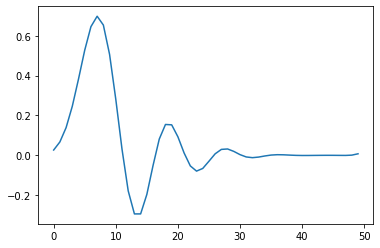

In [10]:
wv = sp.signal.daub(10)
sfreq = 500
wv = lambda: sp.signal.resample(sp.signal.daub(10), sfreq//10)
plt.plot(wv())

In [80]:
%matplotlib inline
sfreq=500
n_channels = 128
spikesgen = SpikesDatasetGenerator(
    tmin=0,
    tmax=1,
    sfreq=sfreq,
    n_spikes=(3, 6),
    n_channels=n_channels,
    spike_chance=.4,
    spike_negativity_chance=.4,
    spike_deviation=.02,
    spike_amplitude_deviation=(1, 3),
    spike_fun=lambda: sp.signal.resample(sp.signal.daub(10), sfreq//20)
)
X, Y = list(), list()
for i, (spike_data, peak_times) in enumerate(spikesgen(1000)):
    if not i%100:
        print(i)

    X.append(spike_data)
    y = np.zeros(spike_data.shape[1])
    for peak in peak_times:
        y[peak] = 1
    Y.append(y)

    # for spike_tc in spike_data:
    #     fig, (ax1, ax2) = plt.subplots(1, 2)
    #     ax1.vlines(peak_times, 0, np.max(spike_tc)+.25*np.max(spike_tc), 'r', linewidth=1.5, alpha=.5)
    #     ax1.plot(spike_tc)

    #     freqs = np.arange(1, sfreq // 2)
    #     cwtmatr = compute_morlet_cwt(spike_tc, np.arange(sfreq)/sfreq, freqs)
    #     mapable = ax2.imshow(
    #         normal_rows(cwtmatr),
    #         # cwtmatr,
    #         aspect='auto',
    #         origin='lower',
    #         cmap='coolwarm',
    #     )
    #     # rect = patches.Rectangle((spike_starttime-5, 2), 15, sfreq//2-5, linewidth=1, edgecolor='r', facecolor='none')
    #     # ax3.add_patch(rect)
    #     ax1.set_title('Signal')
    #     ax2.set_title('CWT')
    #     fig.set_size_inches(15, 5)
    #     # plt.colorbar(mapable, ax=ax3)
    #     plt.show()

# i = 0
# print(np.array(X).shape)
# plt.plot(np.array(X)[i].mean(0))
# plt.vlines(np.where(Y[i]==1)[0], 0, np.max(X[i].mean(0))+.25*np.max(X[i].mean(0)), 'r', linewidth=1.5, alpha=.5)
# plt.show()
# plt.plot(spikesgen._spike)

save_pkl((np.array(X), np.array(Y)), '../Source/spikes_data_128ch_500Hz_1sec.pkl')

0
100
200
300
400
500
600
700
800
900


In [6]:
sfreq=500
n_channels = 64
spikesgen = SpikesDatasetGenerator(
    tmin=0,
    tmax=1,
    sfreq=sfreq,
    n_spikes=(3, 6),
    n_channels=n_channels,
    spike_chance=.4,
    spike_negativity_chance=0.4,
    spike_deviation=.02,
    spike_amplitude_deviation=(1, 3),
    spike_fun=lambda: sp.signal.resample(sp.signal.daub(10), sfreq//20)
)
import mne
%matplotlib qt
for data, peaks in spikesgen(1):
    info = mne.create_info(
        [f'Ch0{i}' for i in range(n_channels)],
        sfreq,
        'eeg',
        False
    )
    events = np.array([
        [peak, 0, 1]
        for peak in peaks
    ])
    raw = mne.io.RawArray(data, info)
    raw.plot(events)

Creating RawArray with float64 data, n_channels=64, n_times=500
    Range : 0 ... 499 =      0.000 ...     0.998 secs
Ready.
Using matplotlib as 2D backend.
Opening raw-browser...


Closing raw-browser...
Channels marked as bad:
none


(1000, 64, 500)


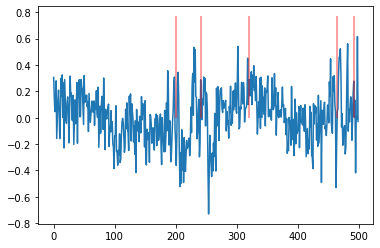

In [56]:
i = np.random.randint(1000)
print(np.array(X).shape)
plt.plot(np.array(X)[i].mean(0))
plt.vlines(np.where(Y[i]==1)[0], 0, np.max(X[i].mean(0))+.25*np.max(X[i].mean(0)), 'r', linewidth=1.5, alpha=.5)
plt.show()
# plt.plot(spikesgen._spike)

In [3]:

X, Y = read_pkl('../Source/spikes_data_128ch_500Hz_1sec.pkl')
X = np.transpose(X, (0, 2, 1))
X_train, X_test, Y_train, Y_test = skm.train_test_split(X, Y)
del X, Y

In [58]:
(X_train.shape, Y_train.shape)

((750, 500, 64), (750, 500))

In [ ]:

# model_des = ModelDesign(
#     tf.keras.Input(X_train.shape[1:]),
#     tf.keras.layers.LSTM(
#         128,
#         return_sequences=True,
#         use_bias=True
#     ),
#     tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(50, activation='relu', kernel_regularizer='l1')),
#     tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(1, activation='sigmoid')),
#     tf.keras.layers.Flatten()
# )

# model_des = ModelDesign(
#     tf.keras.Input(X_train.shape[1:]),
#     tf.keras.layers.Bidirectional(
#         tf.keras.layers.LSTM(
#             64,
#             return_sequences=True,
#             use_bias=True
#         ),
#         merge_mode='ave',
#     ),
#     tf.keras.layers.Dropout(.8),
#     tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(1, activation='sigmoid')),
#     tf.keras.layers.Flatten()
# )

# model_des = ModelDesign(
#     tf.keras.Input(X_train.shape[1:]),
#     tf.keras.layers.Bidirectional(
#         tf.keras.layers.LSTM(
#             64,
#             return_sequences=True,
#             use_bias=True,
#             # bias_regularizer='l1'
#         ),
#         merge_mode='ave'
#     ),
#     tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(50, activation='relu', kernel_regularizer='l1')),
#     tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(50, activation='relu', kernel_regularizer='l1')),
#     tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(1, activation='sigmoid')),
#     tf.keras.layers.Flatten()
# )

# model_des = ModelDesign(
#     tf.keras.Input(X_train.shape[1:]),
#     tf.keras.layers.Bidirectional(
#         tf.keras.layers.LSTM(
#             64,
#             return_sequences=True,
#             use_bias=True
#         ),
#         merge_mode='ave',
#     ),
#     tf.keras.layers.Dropout(.8),
#     tf.keras.layers.LSTM(
#         64,
#         return_sequences=True,
#         use_bias=True
#     ),
#     tf.keras.layers.Dropout(.8),
#     tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(1, activation='sigmoid')),
#     tf.keras.layers.Flatten()
# )

# -0.2833520101973029 nice one
# model_des = ModelDesign(
#     tf.keras.Input(X_train.shape[1:]),
#     tf.keras.layers.Bidirectional(
#         tf.keras.layers.LSTM(
#             128,
#             return_sequences=True,
#             use_bias=True
#         ),
#         merge_mode='ave',
#     ),
#     tf.keras.layers.Dropout(.8),
#     tf.keras.layers.Bidirectional(
#         tf.keras.layers.LSTM(
#             64,
#             return_sequences=True,
#             use_bias=True
#         ),
#         merge_mode='ave',
#     ),
#     tf.keras.layers.Dropout(.8),
#     tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(50, activation=tfa.activations.mish)),
#     tf.keras.layers.Dropout(.8),
#     tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(1, activation='sigmoid')),
#     tf.keras.layers.Flatten()
# )

# -0.28383327771166167
# model_des = ModelDesign(
#     tf.keras.Input(X_train.shape[1:]),
#     tf.keras.layers.Bidirectional(
#         tf.keras.layers.LSTM(
#             128,
#             return_sequences=True,
#             use_bias=True
#         ),
#         merge_mode='ave',
#     ),
#     tf.keras.layers.Dropout(.8),
#     tf.keras.layers.Bidirectional(
#         tf.keras.layers.LSTM(
#             64,
#             return_sequences=True,
#             use_bias=True
#         ),
#         merge_mode='ave',
#     ),
#     tf.keras.layers.Dropout(.8),
#     tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(50, activation=tfa.activations.mish)),
#     tf.keras.layers.Dropout(.8),
#     tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(50, activation=tfa.activations.mish)),
#     tf.keras.layers.Dropout(.8),
#     tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(1, activation='sigmoid')),
#     tf.keras.layers.Flatten()
# )

# -0.30912042992920413
# model_des = ModelDesign(
#     tf.keras.Input(X_train.shape[1:]),
#     tf.keras.layers.Bidirectional(
#         tf.keras.layers.LSTM(
#             128,
#             return_sequences=True,
#             use_bias=True
#         ),
#         merge_mode='ave',
#     ),
#     tf.keras.layers.Dropout(.8),
#     tf.keras.layers.Bidirectional(
#         tf.keras.layers.LSTM(
#             64,
#             return_sequences=True,
#             use_bias=True
#         ),
#         merge_mode='ave',
#     ),
#     tf.keras.layers.Dropout(.8),
#     tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(50, activation=tfa.activations.mish, kernel_regularizer='l1')),
#     tf.keras.layers.Dropout(.8),
#     tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(1, activation='sigmoid')),
#     tf.keras.layers.Flatten()
# )

# -0.08922844078955648
# model_des = ModelDesign(
#     tf.keras.Input(X_train.shape[1:]),
#     tf.keras.layers.Bidirectional(
#         tf.keras.layers.LSTM(
#             128,
#             return_sequences=True,
#             use_bias=True
#         ),
#         merge_mode='ave',
#     ),
#     tf.keras.layers.Dropout(.8),
#     tf.keras.layers.Bidirectional(
#         tf.keras.layers.LSTM(
#             64,
#             return_sequences=True,
#             use_bias=True
#         ),
#         merge_mode='ave',
#     ),
#     tf.keras.layers.Dropout(.8),
#     tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(50, activation=tfa.activations.mish, kernel_regularizer='l1')),
#     tf.keras.layers.Dropout(.8),
#     tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(50, activation=tfa.activations.mish, kernel_regularizer='l1')),
#     tf.keras.layers.Dropout(.8),
#     tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(1, activation='sigmoid')),
#     tf.keras.layers.Flatten()
# )

# -0.28020170871617334
# model_des = ModelDesign(
#     tf.keras.Input(X_train.shape[1:]),
#     tf.keras.layers.Bidirectional(
#         tf.keras.layers.LSTM(
#             128,
#             return_sequences=True,
#             use_bias=True
#         ),
#         merge_mode='ave',
#     ),
#     tf.keras.layers.Dropout(.8),
#     tf.keras.layers.Bidirectional(
#         tf.keras.layers.LSTM(
#             64,
#             return_sequences=True,
#             use_bias=True
#         ),
#         merge_mode='ave',
#     ),
#     tf.keras.layers.Dropout(.8),
#     tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(50, activation=tfa.activations.mish, kernel_regularizer='l2')),
#     tf.keras.layers.Dropout(.8),
#     tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(1, activation='sigmoid')),
#     tf.keras.layers.Flatten()
# )

# -0.30842556322541015
# model_des = ModelDesign(
#     tf.keras.Input(X_train.shape[1:]),
#     tf.keras.layers.Bidirectional(
#         tf.keras.layers.LSTM(
#             128,
#             return_sequences=True,
#             use_bias=True
#         ),
#         merge_mode='ave',
#     ),
#     tf.keras.layers.Dropout(.8),
#     tf.keras.layers.Bidirectional(
#         tf.keras.layers.LSTM(
#             64,
#             return_sequences=True,
#             use_bias=True
#         ),
#         merge_mode='ave',
#     ),
#     tf.keras.layers.Dropout(.8),
#     tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(50, activation=tfa.activations.mish)),
#     tf.keras.layers.Dropout(.8),
#     tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(50, activation=tfa.activations.mish, kernel_regularizer='l2')),
#     tf.keras.layers.Dropout(.8),
#     tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(1, activation='sigmoid')),
#     tf.keras.layers.Flatten()
# )

# model_des = ModelDesign(
#     tf.keras.Input(X_train.shape[1:]),
#     tf.keras.layers.Bidirectional(
#         tf.keras.layers.LSTM(
#             128,
#             return_sequences=True,
#             use_bias=True
#         ),
#         merge_mode='ave',
#     ),
#     tf.keras.layers.Dropout(.8),
#     tf.keras.layers.Bidirectional(
#         tf.keras.layers.LSTM(
#             64,
#             return_sequences=True,
#             use_bias=True
#         ),
#         merge_mode='ave',
#     ),
#     tf.keras.layers.Dropout(.8),
#     tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(150, activation=tfa.activations.mish)),
#     tf.keras.layers.Dropout(.8),
#     tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(100, activation=tfa.activations.mish)),
#     tf.keras.layers.Dropout(.8),
#     tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(50, activation=tfa.activations.mish, kernel_regularizer='l2')),
#     tf.keras.layers.Dropout(.8),
#     tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(1, activation='sigmoid')),
#     tf.keras.layers.Flatten()
# )

# -0.30636945155826395
model_des = ModelDesign(
    tf.keras.Input(X_train.shape[1:]),
    tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(
            128,
            return_sequences=True,
            use_bias=True
        ),
        merge_mode='ave',
    ),
    tf.keras.layers.Dropout(.8),
    tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(
            64,
            return_sequences=True,
            use_bias=True
        ),
        merge_mode='ave',
    ),
    tf.keras.layers.Dropout(.8),
    tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(50, activation=tfa.activations.mish, kernel_regularizer='l2')),
    tf.keras.layers.Dropout(.8),
    tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(50, activation=tfa.activations.mish, kernel_regularizer='l2')),
    tf.keras.layers.Dropout(.8),
    tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(1, activation='sigmoid')),
    tf.keras.layers.Flatten()
)

# model_des = ModelDesign(
#     tf.keras.Input(X_train.shape[1:]),
#     tf.keras.layers.Bidirectional(
#         tf.keras.layers.LSTM(
#             128,
#             return_sequences=True,
#             use_bias=True
#         ),
#         merge_mode='ave',
#     ),
#     tf.keras.layers.Dropout(.8),
#     tf.keras.layers.Bidirectional(
#         tf.keras.layers.LSTM(
#             64,
#             return_sequences=True,
#             use_bias=True
#         ),
#         merge_mode='ave',
#     ),
#     tf.keras.layers.Dropout(.8),
#     tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(50, activation=tfa.activations.mish, kernel_regularizer='l2')),
#     tf.keras.layers.Dropout(.8),
#     tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(50, activation=tfa.activations.mish, kernel_regularizer='l2')),
#     tf.keras.layers.Dropout(.8),
#     tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(1, activation='sigmoid')),
#     tf.keras.layers.Flatten(),
#     LayerDesign(lambda x: tf.cast(tf.math.greater(x, .5), tf.float32))
# )

# -0.2712548070694161
# model_des = ModelDesign(
#     tf.keras.Input(X_train.shape[1:]),
#     tf.keras.layers.Bidirectional(
#         tf.keras.layers.LSTM(
#             128,
#             return_sequences=True,
#             use_bias=True
#         ),
#         merge_mode='ave',
#     ),
#     tf.keras.layers.Dropout(.8),
#     tf.keras.layers.Bidirectional(
#         tf.keras.layers.LSTM(
#             64,
#             return_sequences=True,
#             use_bias=True
#         ),
#         merge_mode='ave',
#     ),
#     tf.keras.layers.Dropout(.8),
#     tf.keras.layers.Bidirectional(
#         tf.keras.layers.LSTM(
#             32,
#             return_sequences=True,
#             use_bias=True
#         ),
#         merge_mode='ave',
#     ),
#     tf.keras.layers.Dropout(.8),
#     tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(50, activation=tfa.activations.mish)),
#     tf.keras.layers.Dropout(.8),
#     tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(1, activation='sigmoid')),
#     tf.keras.layers.Flatten()
# )

# can not train
# model_des = ModelDesign(
#     tf.keras.Input(X_train.shape[1:]),
#     tf.keras.layers.Bidirectional(
#         tf.keras.layers.LSTM(
#             128,
#             return_sequences=True,
#             use_bias=True
#         ),
#         merge_mode='ave',
#     ),
#     tf.keras.layers.Dropout(.8),
#     tf.keras.layers.Bidirectional(
#         tf.keras.layers.LSTM(
#             64,
#             return_sequences=True,
#             use_bias=True
#         ),
#         merge_mode='ave',
#     ),
#     tf.keras.layers.Dropout(.8),
#     tf.keras.layers.Bidirectional(
#         tf.keras.layers.LSTM(
#             32,
#             return_sequences=True,
#             use_bias=True
#         ),
#         merge_mode='ave',
#     ),
#     tf.keras.layers.Dropout(.8),
#     tf.keras.layers.Bidirectional(
#         tf.keras.layers.LSTM(
#             16,
#             return_sequences=True,
#             use_bias=True
#         ),
#         merge_mode='ave',
#     ),
#     tf.keras.layers.Dropout(.8),
#     tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(50, activation=tfa.activations.mish)),
#     tf.keras.layers.Dropout(.8),
#     tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(1, activation='sigmoid')),
#     tf.keras.layers.Flatten()
# )

# model_des = ModelDesign(
#     tf.keras.Input(X_train.shape[1:]),
#     tf.keras.layers.Bidirectional(
#         tf.keras.layers.LSTM(
#             128,
#             return_sequences=True,
#             use_bias=True
#         ),
#         merge_mode='ave',
#     ),
#     tf.keras.layers.Dropout(.8),
#     tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(50, activation=tfa.activations.mish, kernel_regularizer='l2')),
#     tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(1, activation='sigmoid')),
#     tf.keras.layers.Flatten(),
#        # layer to make output either 0 or 1
#     LayerDesign(lambda x: tf.cast(tf.math.greater(x, .5), tf.float32))
# )

model_des()

model = model_des.build()

model.compile(optimizer='adam',
    loss='cosine_similarity'
)

model.fit(
    X_train,
    Y_train,
    epochs=200,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)],
    batch_size=200,
    validation_split=0.25
)

In [9]:
from keras.layers import Layer
import keras.backend as K

class Attention(Layer):
    def __init__(self,**kwargs):
        super(Attention,self).__init__(**kwargs)

    def build(self,input_shape):
        self.W=self.add_weight(
            name='attention_weight',
            shape=(input_shape[-1],1),
            initializer='random_normal',
            trainable=True
        )
        self.b=self.add_weight(
            name='attention_bias',
            shape=(input_shape[1],1),
            initializer='zeros',
            trainable=True
        )
        super(Attention, self).build(input_shape)

    def call(self,x):
        # Alignment scores. Pass them through tanh function
        e = K.tanh(K.dot(x,self.W)+self.b)
        # Remove dimension of size 1
        e = K.squeeze(e, axis=-1)
        # Compute the weights
        alpha = K.softmax(e)
        # Reshape to tensorFlow format
        alpha = K.expand_dims(alpha, axis=-1)
        # Compute the context vector
        context = x * alpha
        context = K.sum(context, axis=1)
        return context

In [74]:
# -0.34740586772409116
# model_des = ModelDesign(
#     tf.keras.Input(X_train.shape[1:]),
#     tf.keras.layers.Bidirectional(
#         tf.keras.layers.LSTM(
#             128,
#             return_sequences=True,
#             use_bias=True
#         ),
#         merge_mode='ave',
#     ),
#     tf.keras.layers.Dropout(.8),
#     LayerDesign(tf.transpose, (0, 2, 1)),
#     Attention(),
#     LayerDesign(tf.expand_dims, 2),
#     LayerDesign(tf.expand_dims, 2),
#     tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(50, activation=tfa.activations.mish, kernel_regularizer='l2')),
#     tf.keras.layers.Dropout(.8),
#     # tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(50, activation=tfa.activations.mish, kernel_regularizer='l2')),
#     # tf.keras.layers.Dropout(.8),
#     tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(1, activation='sigmoid')),
#     tf.keras.layers.Flatten()
# )

# wonderful
# -0.3508691212034058
# model_des = ModelDesign(
#     tf.keras.Input(X_train.shape[1:]),
#     tf.keras.layers.Bidirectional(
#         tf.keras.layers.LSTM(
#             128,
#             return_sequences=True,
#             use_bias=True
#         ),
#         merge_mode='ave',
#     ),
#     tf.keras.layers.Dropout(.8),
#     tf.keras.layers.Bidirectional(
#         tf.keras.layers.LSTM(
#             64,
#             return_sequences=True,
#             use_bias=True
#         ),
#         merge_mode='ave',
#     ),
#     tf.keras.layers.Dropout(.8),
#     LayerDesign(tf.transpose, (0, 2, 1)),
#     Attention(),
#     LayerDesign(tf.expand_dims, 2),
#     LayerDesign(tf.expand_dims, 2),
#     tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(50, activation=tfa.activations.mish, kernel_regularizer='l2')),
#     tf.keras.layers.Dropout(.8),
#     # tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(50, activation=tfa.activations.mish, kernel_regularizer='l2')),
#     # tf.keras.layers.Dropout(.8),
#     tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(1, activation='sigmoid')),
#     tf.keras.layers.Flatten()
# )

# -0.36972440021689107
model_des = ModelDesign(
    tf.keras.Input(X_train.shape[1:]),
    tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(
            128,
            return_sequences=True,
            use_bias=True
        ),
        merge_mode='ave',
    ),
    tf.keras.layers.Dropout(.8),
    tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(
            64,
            return_sequences=True,
            use_bias=True
        ),
        merge_mode='ave',
    ),
    tf.keras.layers.Dropout(.8),
    LayerDesign(tf.transpose, (0, 2, 1)),
    Attention(),
    LayerDesign(tf.expand_dims, 2),
    LayerDesign(tf.expand_dims, 2),
    tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(50, activation=tfa.activations.mish, kernel_regularizer='l2')),
    tf.keras.layers.Dropout(.8),
    tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(50, activation=tfa.activations.mish, kernel_regularizer='l2')),
    tf.keras.layers.Dropout(.8),
    tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(1, activation='sigmoid')),
    tf.keras.layers.Flatten()
)

# model_des()
model = model_des.build()

model.compile(optimizer='adam',
    loss='cosine_similarity'
)

model.fit(
    X_train,
    Y_train,
    epochs=200,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)],
    batch_size=200,
    validation_split=0.25
)

Epoch 1/200
3/3 [==============================] - 101s 4s/step - loss: 0.4363 - val_loss: 0.4238
Epoch 2/200
3/3 [==============================] - 9s 3s/step - loss: 0.4176 - val_loss: 0.4054
Epoch 3/200
3/3 [==============================] - 10s 3s/step - loss: 0.3994 - val_loss: 0.3875
Epoch 4/200
3/3 [==============================] - 9s 3s/step - loss: 0.3817 - val_loss: 0.3701
Epoch 5/200
3/3 [==============================] - 9s 3s/step - loss: 0.3645 - val_loss: 0.3533
Epoch 6/200
3/3 [==============================] - 8s 3s/step - loss: 0.3477 - val_loss: 0.3369
Epoch 7/200
3/3 [==============================] - 9s 3s/step - loss: 0.3315 - val_loss: 0.3210
Epoch 8/200
3/3 [==============================] - 9s 3s/step - loss: 0.3158 - val_loss: 0.3057
Epoch 9/200
3/3 [==============================] - 9s 3s/step - loss: 0.3007 - val_loss: 0.2908
Epoch 10/200
3/3 [==============================] - 9s 3s/step - loss: 0.2859 - val_loss: 0.2765
Epoch 11/200
3/3 [==================

In [75]:
Y_p = model(X_test).numpy()
tf.keras.losses.CosineSimilarity()(Y_test.astype(float), Y_p.astype(float))

<tf.Tensor: shape=(), dtype=float64, numpy=-0.36972440021689107>

209


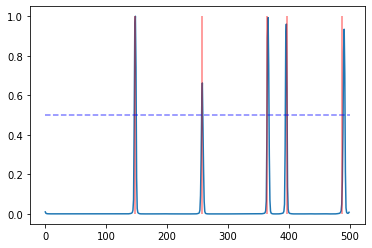

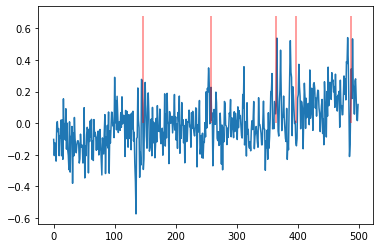

In [107]:
%matplotlib inline
def n_max_values(n, seq):
    return sorted(seq, reverse=True)[:n]

i = np.random.randint(Y_p.shape[0])
print(i)
# plt.plot(Y_p[i], '.')
# plt.show()
plt.plot((Y_p[i] - Y_p[i].min())/(Y_p[i].max() - Y_p[i].min()))
plt.vlines(np.where(Y_test[i]==1)[0], 0, 1, 'r', linewidth=1.5, alpha=.5)
plt.hlines(.5, 0, 500, 'b', linewidth=1.5, alpha=.5, linestyle='--')
plt.show()

plt.plot(X_test[i].mean(1))
plt.vlines(np.where(Y_test[i]==1)[0], 0, np.max(X_test[i].mean(1))+.25*np.max(X_test[i].mean(1)), 'r', linewidth=1.5, alpha=.5)
plt.show()
# n_preds = int(Y_test[i].sum())
# # for yp, yt in zip(sorted(Y_p[i], reverse=True), sorted(Y_test[i], reverse=True)):
# for yp, yt in zip(Y_p[i], Y_test[i]):
#     max_preds = n_max_values(n_preds, Y_p[i])
#     # print(max_preds)
#     if yp in max_preds:
#         out = 1
#     else:
#         out = 0
#     if yt > 0 :
#         print('--------')
#         print(out, yp, int(yt))
#         print('--------')
#     else:
#         print(out, yp, int(yt))